In [258]:
import os
import tarfile
from six.moves import urllib
import email
import email.policy
import re
from html import unescape
import nltk
import urlextract
import numpy as np
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

# About the data

  - spam: 500 spam messages, all received from non-spam-trap sources.

  - easy_ham: 2500 non-spam messages.  These are typically quite easy to
    differentiate from spam, since they frequently do not contain any spammish
    signatures (like HTML etc).
    
  - hard_ham: 250 non-spam messages which are closer in many respects to
    typical spam: use of HTML, unusual HTML markup, coloured text,
    "spammish-sounding" phrases etc.
  
Source: https://spamassassin.apache.org/old/publiccorpus/readme.html

In [2]:
DOWNLOAD_ROOT = "https://spamassassin.apache.org/old/publiccorpus/"
DATASETS_PATH = os.path.join("Datasets")
FILES = ["20030228_easy_ham.tar.bz2",
         "20030228_hard_ham.tar.bz2",
         "20030228_spam.tar.bz2",]
DOWNLOAD_URLS = [DOWNLOAD_ROOT + name for name in FILES]

def fetch_data():
    if not os.path.isdir(DATASETS_PATH):
        os.makedirs(DATASETS_PATH)
        
    for filename, url in list(zip(FILES, DOWNLOAD_URLS)):
        path = os.path.join(DATASETS_PATH, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        current_tar_file = tarfile.open(path)
        current_tar_file.extractall(path=DATASETS_PATH)
        current_tar_file.close()
        

In [3]:
fetch_data()

In [4]:
spam_path = os.path.join(DATASETS_PATH, 'spam')
ham_path = os.path.join(DATASETS_PATH, 'easy_ham')
hardham_path = os.path.join(DATASETS_PATH, 'hard_ham')
spam_filenames = [filename for filename in os.listdir(spam_path) if len(filename) > 10]
ham_filenames = [filename for filename in os.listdir(ham_path) if len(filename) > 10]
hardham_filenames = [filename for filename in os.listdir(hardham_path) if len(filename) > 10]

print("Spam emails:", len(spam_filenames), "\nNon-spam emails:", len(ham_filenames) + len(hardham_filenames))

Spam emails: 500 
Non-spam emails: 2750


In [5]:
def read_email(filename, directory):
    with open(os.path.join(DATASETS_PATH, directory, filename), "rb") as f:        
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

    
spam_emails = [read_email(filename=filename, directory="spam") for filename in spam_filenames]
ham_emails = [read_email(filename=filename, directory="easy_ham") for filename in ham_filenames]
hardham_emails = [read_email(filename=filename, directory="hard_ham") for filename in hardham_filenames]

# unite ham and hardham into one nonspam category
ham_emails = ham_emails + hardham_emails

In [6]:
# Spam examle
print(spam_emails[0].get_content())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD>
<META content="text/html; charset=windows-1252" http-equiv=Content-Type>
<META content="MSHTML 5.00.2314.1000" name=GENERATOR></HEAD>
<BODY><!-- Inserted by Calypso -->
<TABLE border=0 cellPadding=0 cellSpacing=2 id=_CalyPrintHeader_ rules=none 
style="COLOR: black; DISPLAY: none" width="100%">
  <TBODY>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TD></TR>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso --><FONT 
color=#000000 face=VERDANA,ARIAL,HELVETICA size=-2><BR></FONT></TD></TR></TABLE><!-- End Calypso --><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Why Spend More Than You Have To?
<CENTER><FONT color=#ff0000 face="Copp

In [7]:
# Nonspam example
print(ham_emails[6].get_content())

The Scotsman - 22 August 2002

 Playboy wants to go out with a bang 
 
 
 AN AGEING Berlin playboy has come up with an unusual offer to lure women into
 his bed - by promising the last woman he sleeps with an inheritance of 250,000
 (£160,000). 
 
 Rolf Eden, 72, a Berlin disco owner famous for his countless sex partners,
 said he could imagine no better way to die than in the arms of an attractive
 young woman - preferably under 30. 
 
 "I put it all in my last will and testament - the last woman who sleeps with
 me gets all the money," Mr Eden told Bild newspaper. 
 
 "I want to pass away in the most beautiful moment of my life. First a lot of
 fun with a beautiful woman, then wild sex, a final orgasm - and it will all
 end with a heart attack and then Im gone." 
 
 Mr Eden, who is selling his nightclub this year, said applications should be
 sent in quickly because of his age. "It could end very soon," he said.


------------------------ Yahoo! Groups Sponsor ---------------------~

# Train and test split

In [8]:
X = ham_emails + spam_emails
y = [0]*len(ham_emails) + [1]*len(spam_emails)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# Converting emails into text

In [9]:
def clean_html(raw_html):
    cleantext = re.sub(r'<a.+?>', ' href url ', raw_html, flags=re.I | re.S | re.M) 
    cleantext = re.sub(r'<.+?>', ' ', cleantext, flags=re.S | re.M)
    cleantext = re.sub(r'\s+', ' ', cleantext) 
    return unescape(cleantext)


In [10]:
cleaned_sample = clean_html(spam_emails[0].get_content())
print(cleaned_sample)

 Save up to 70% on Life Insurance. Why Spend More Than You Have To? Life Quote Savings Ensuring your family's financial security is very important. Life Quote Savings makes buying life insurance simple and affordable. We Provide FREE Access to The Very Best Companies and The Lowest Rates. Life Quote Savings is FAST, EASY and SAVES you money! Let us help you get started with the best values in the country on new coverage. You can SAVE hundreds or even thousands of dollars by requesting a FREE quote from Lifequote Savings. Our service will take you less than 5 minutes to complete. Shop and compare. SAVE up to 70% on all types of Life insurance! href url Click Here For Your Free Quote! Protecting your family is the best investment you'll ever make! If you are in receipt of this email in error and/or wish to be removed from our list, href url PLEASE CLICK HERE AND TYPE REMOVE. If you reside in any state which prohibits e-mail solicitations for insurance, please disregard this email. 


In [11]:
def email_to_text(raw_email):
    html = None
    for part in raw_email.walk():
        ctype = part.get_content_type()
        if ctype not in ('text/html', 'text/plain'):
            continue
        try:
            content = part.get_content()
        except:
            content = str(part.get_payload())
        if ctype == 'text/plain':
            return content
        else:
            html = content
    if html:
        return clean_html(html)
    

In [12]:
print(email_to_text(spam_emails[0])[:100], "...")

 Save up to 70% on Life Insurance. Why Spend More Than You Have To? Life Quote Savings Ensuring your ...


# Counting words in email

In [13]:
stemmer = nltk.PorterStemmer()
for word in ("Universe", "Universal", "University", "Computed", "Compute", "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Universe => univers
Universal => univers
University => univers
Computed => comput
Compute => comput
Compulsive => compuls


Universe, Universal, and University have the same stem but different meanings, however that wont be a huge problem

In [14]:
url_extractor = urlextract.URLExtract()
print(url_extractor.find_urls(email_to_text(spam_emails[1])))

['http://www.adclick.ws/p.cfm?o=315&s=pk007', 'http://www.adclick.ws/p.cfm?o=249&s=pk007', 'http://www.adclick.ws/p.cfm?o=245&s=pk002', 'http://www.adclick.ws/p.cfm?o=259&s=pk007', 'http://www.adclick.ws/p.cfm?o=283&s=pk007', 'http://www.qves.com/trim/?ilug@linux.ie%7C17%7C114258', 'http://www.linux.ie/mailman/listinfo/ilug']


In [15]:
class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):    
    def __init__(self, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_numbers = replace_numbers
        self.stemming = stemming
        self.replace_urls = replace_urls
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        if not isinstance(X, list):
            X = [X]
        for email in X:            
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls:
                urls = url_extractor.find_urls(text)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', ' NUMBER ', text, flags=re.M | re.S)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M | re.S)
            word_counts = Counter(text.split())
            if self.stemming:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)    
    

In [16]:
some_email = spam_emails[:3]
some_email_wordcounts = EmailToWordCounterTransformer().fit_transform(some_email)
some_email_wordcounts

array([Counter({'save': 8, 'you': 8, 'to': 6, 'life': 6, 'and': 6, 'quot': 5, 'the': 5, 'insur': 4, 'in': 4, 'number': 3, 'on': 3, 'your': 3, 'is': 3, 'free': 3, 'best': 3, 'of': 3, 'up': 2, 'than': 2, 'famili': 2, 'veri': 2, 'make': 2, 'or': 2, 'from': 2, 'our': 2, 'type': 2, 'href': 2, 'url': 2, 'click': 2, 'here': 2, 'for': 2, 'if': 2, 'thi': 2, 'email': 2, 'remov': 2, 'pleas': 2, 'whi': 1, 'spend': 1, 'more': 1, 'have': 1, 'ensur': 1, 's': 1, 'financi': 1, 'secur': 1, 'import': 1, 'buy': 1, 'simpl': 1, 'afford': 1, 'we': 1, 'provid': 1, 'access': 1, 'compani': 1, 'lowest': 1, 'rate': 1, 'fast': 1, 'easi': 1, 'money': 1, 'let': 1, 'us': 1, 'help': 1, 'get': 1, 'start': 1, 'with': 1, 'valu': 1, 'countri': 1, 'new': 1, 'coverag': 1, 'can': 1, 'hundr': 1, 'even': 1, 'thousand': 1, 'dollar': 1, 'by': 1, 'request': 1, 'a': 1, 'lifequot': 1, 'servic': 1, 'will': 1, 'take': 1, 'less': 1, 'minut': 1, 'complet': 1, 'shop': 1, 'compar': 1, 'all': 1, 'protect': 1, 'invest': 1, 'll': 1, 'ever':

# Vectorization

Now it's time to vectorize all counted words:
 
1. First I will count all words
2. Most common of them I will store in a N=1000 size dictionary 
3. All my vectors I will store in a <a href="https://machinelearningmastery.com/sparse-matrices-for-machine-learning/">sparce matrix</a> to decrease computational and space costs

In [17]:
class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):    
    def __init__(self, vocabulary_size=1000, word_max_occurrence=10):
        self.vocabulary_size = vocabulary_size
        self.word_max_occurrence = word_max_occurrence
    
    def fit(self, X, y=None):
        total_count = Counter()  
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, self.word_max_occurrence)  # to prevent word occurrence more than X times at one email
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}  # +1 for top-1 (not top-0)
        return self
    
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for i, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(i)                
                cols.append(self.vocabulary_.get(word, 0))  # Store a word's index. 
                                                            # If a word isn't common then append it to index 0
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))
    

In [18]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
few_vectors = vocab_transformer.fit_transform(some_email_wordcounts)
few_vectors

<3x11 sparse matrix of type '<class 'numpy.int32'>'
	with 25 stored elements in Compressed Sparse Row format>

In [19]:
# Top N=10 of most common words
vocab_transformer.vocabulary_

{'number': 1,
 'url': 2,
 'the': 3,
 'you': 4,
 'to': 5,
 'save': 6,
 'life': 7,
 'and': 8,
 'in': 9,
 'quot': 10}

In [20]:
few_vectors.toarray()

array([[126,   3,   2,   5,   8,   6,   8,   6,   6,   4,   5],
       [ 62,   8,   7,   4,   2,   2,   0,   0,   0,   1,   0],
       [ 46,   8,   6,   4,   2,   2,   0,   0,   0,   1,   0]],
      dtype=int32)

This array shows that the first email has 126 non common words, 3 'number', 2 'url', ... , 4 'in', 5 'quot'.

# Transformation pipeline 

In [21]:
preprocess_pipeline = Pipeline([
    ('email_to_words', EmailToWordCounterTransformer()),
    ('words_to_vectors', WordCounterToVectorTransformer()),
])

In [22]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

# Models evaluating

In [290]:
# I will use multiple scorers to evaluate models
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

def print_scores(score):
    #print("Accuracy:  {:0.2f}%".format(100*score['test_accuracy'].mean()))
    print("Precision: {:0.2f}%".format(100*score['test_precision'].mean()))
    print("Recall:    {:0.2f}%".format(100*score['test_recall'].mean()))
    print("F1 score:  {:0.2f}%".format(100*score['test_f1'].mean()))

#### Logistic Regression

In [261]:
log_clsf = LogisticRegression(solver='liblinear', random_state=11)
score = cross_validate(log_clsf, X_train_prepared, y_train, cv=3, verbose=3, scoring=scoring)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV]  , accuracy=0.971, f1=0.905, precision=0.930, recall=0.881, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
c:\users\batyr\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  , accuracy=0.967, f1=0.888, precision=0.927, recall=0.852, total=   0.3s
[CV]  ................................................................
[CV]  , accuracy=0.973, f1=0.909, precision=0.966, recall=0.858, total=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


In [262]:
print_scores(score)

Precision: 94.12%
Recall:    86.38%
F1 score:  90.07%


It seems that I need to increase max_iter to achieve convergence and better results. But I leave it to a grid search 

#### Support Vector Machine

In [152]:
from sklearn.svm import SVC

sv_clsf = SVC(gamma='auto', random_state=11)
score = cross_validate(sv_clsf, X_train_prepared, y_train, cv=3, verbose=3, scoring=scoring)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV]  , accuracy=0.940, f1=0.770, precision=0.956, recall=0.644, total=   2.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  , accuracy=0.943, f1=0.786, precision=0.957, recall=0.667, total=   1.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV]  , accuracy=0.942, f1=0.775, precision=0.977, recall=0.642, total=   1.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s finished


In [153]:
print_scores(score)

Precision: 96.36%
Recall:    65.10%
F1 score:  77.69%


#### K-Neighbors

In [154]:
from sklearn.neighbors import KNeighborsClassifier

nk_clsf = KNeighborsClassifier()
score = cross_validate(nk_clsf, X_train_prepared, y_train, cv=3, verbose=3, scoring=scoring)

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  , accuracy=0.913, f1=0.641, precision=0.905, recall=0.496, total=   0.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  , accuracy=0.915, f1=0.644, precision=0.918, recall=0.496, total=   0.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  , accuracy=0.924, f1=0.705, precision=0.878, recall=0.590, total=   0.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s finished


In [155]:
print_scores(score)

Precision: 90.03%
Recall:    52.74%
F1 score:  66.36%


#### Decision tree

In [156]:
from sklearn.tree import DecisionTreeClassifier

tree_clsf = DecisionTreeClassifier()
score = cross_validate(tree_clsf, X_train_prepared, y_train, cv=3, verbose=3, scoring=scoring)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
[CV]  , accuracy=0.939, f1=0.801, precision=0.811, recall=0.793, total=   0.1s
[CV]  ................................................................
[CV]  , accuracy=0.934, f1=0.799, precision=0.764, recall=0.837, total=   0.1s
[CV]  ................................................................
[CV]  , accuracy=0.938, f1=0.791, precision=0.823, recall=0.761, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


In [157]:
print_scores(score)

Precision: 79.89%
Recall:    79.69%
F1 score:  79.69%


#### Gaussian process

In [158]:
from sklearn.gaussian_process import GaussianProcessClassifier

gaus_clsf = GaussianProcessClassifier()
score = cross_validate(gaus_clsf, X_train_prepared.toarray(), y_train, cv=3, verbose=3, scoring=scoring)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV]  , accuracy=0.935, f1=0.765, precision=0.883, recall=0.674, total=   8.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV]  , accuracy=0.920, f1=0.732, precision=0.770, recall=0.696, total=   8.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.5s remaining:    0.0s


[CV]  , accuracy=0.927, f1=0.736, precision=0.838, recall=0.657, total=   8.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.3s finished


In [159]:
print_scores(score)

Precision: 83.07%
Recall:    67.57%
F1 score:  74.42%


# Tuning model

In [179]:
log_pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
    ('model', LogisticRegression(solver='liblinear', random_state=11))
])

In [206]:
param_grid = [
    {'preprocess__email_to_words__lower_case': [True, False], 
    'preprocess__email_to_words__remove_punctuation': [True, False],
    'preprocess__email_to_words__replace_urls': [True, False],
    'preprocess__email_to_words__replace_numbers': [True, False],
    'preprocess__email_to_words__stemming': [True, False],
    'preprocess__words_to_vectors__vocabulary_size': [1000],
    'preprocess__words_to_vectors__word_max_occurrence': [10],
    'model__max_iter': [300]
    }
]

In [207]:
grid_search = GridSearchCV(log_pipeline, param_grid=param_grid, cv=3, scoring='precision')

In [208]:
grid_search.fit(X_train, y_train)

c:\users\batyr\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        Pipeline(memory=None,
                                                 steps=[('email_to_words',
                                                         EmailToWordCounterTransformer(lower_case=True,
                                                                                       remove_punctuation=True,
                                                                                       replace_numbers=True,
                                                                                       replace_urls=True,
                                                                                       stemming=True)),
                                                        ('words_to_vectors',
                                                         WordCounterToVectorTransformer(vocabulary_s

In [211]:
grid_search.best_params_

{'model__max_iter': 300,
 'preprocess__email_to_words__lower_case': True,
 'preprocess__email_to_words__remove_punctuation': True,
 'preprocess__email_to_words__replace_numbers': False,
 'preprocess__email_to_words__replace_urls': True,
 'preprocess__email_to_words__stemming': True,
 'preprocess__words_to_vectors__vocabulary_size': 1000,
 'preprocess__words_to_vectors__word_max_occurrence': 10}

In [297]:
final_model = grid_search.best_estimator_

X_test_prepared = final_model.named_steps['preprocess'].transform(X_test)
y_test_predicted = final_model.named_steps['model'].predict(X_test_prepared)

print("Accuracy:  {:.2f}%".format(100*accuracy_score(y_test, y_test_predicted)))
print("Precision: {:.2f}%".format(100*precision_score(y_test, y_test_predicted)))
print("Recall:    {:.2f}%".format(100*recall_score(y_test, y_test_predicted)))
print("F1 score:  {:.2f}%".format(100*f1_score(y_test, y_test_predicted)))

Accuracy:  98.31%
Precision: 97.75%
Recall:    90.62%
F1 score:  94.05%


Pretty good!

# Precision/Recall tradeoff

In [302]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

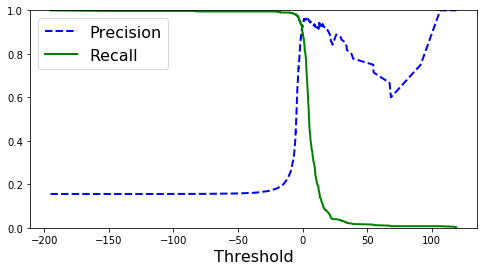

In [300]:
y_scores = cross_val_predict(final_model, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

If I take more precision the recall drop will be too much.

# Reviewing results

Let's see most spammish and anti-spam words

In [213]:
coefs = final_model.named_steps['model'].coef_[0]
vocabulary = preprocess_pipeline.named_steps['words_to_vectors'].vocabulary_
vocabulary['noncommon'] = 0
spam_words = [(value, word) for value, word in list(zip(coefs, vocabulary)) if value > 0]
ham_words = [(value, word) for value, word in list(zip(coefs, vocabulary)) if value < 0] 

In [214]:
print("Top 20 anti-spam markers:")
ham_words.sort()
ham_words[:20]

Top 20 anti-spam markers:


[(-1.6430561717607186, 'way'),
 (-1.2682652702941188, 'inform'),
 (-1.0476872394045404, 'more'),
 (-0.8493133943275836, 'over'),
 (-0.7292422769609531, 'yourself'),
 (-0.7104466004717472, 'million'),
 (-0.6596127142366648, 'think'),
 (-0.652978050101311, 'media'),
 (-0.6418749925876112, 'base'),
 (-0.6140652154025061, 'com'),
 (-0.5943575517479203, 'here'),
 (-0.5868792151129972, 'see'),
 (-0.5856171498093449, 'on'),
 (-0.5835204024455429, 'develop'),
 (-0.5430696696890677, 'attack'),
 (-0.5343835930882822, 'same'),
 (-0.5327165620176924, 'one'),
 (-0.5260718555385675, 'subscrib'),
 (-0.5185303620700766, 'p'),
 (-0.5106674873303981, 'first')]

In [216]:
print("Top 20 spam markers:")
spam_words.sort(reverse=True)
spam_words[:20]

Top 20 spam markers:


[(1.187918471365849, 'spam'),
 (0.9435783216581307, 'network'),
 (0.8991373011940277, 'oh'),
 (0.7445730381618766, 'initi'),
 (0.7222596768721063, '_______________________________________________'),
 (0.7119773005209545, 'control'),
 (0.6666499227106422, 'our'),
 (0.655295143895795, 'seem'),
 (0.6465370380717864, 'includ'),
 (0.6147063897163981, 'come'),
 (0.6106844832948731, 'ha'),
 (0.6066619347661683, 'product'),
 (0.606312328753184, 'bring'),
 (0.5962277484465633, 'some'),
 (0.5759997066372041, 'run'),
 (0.5625755860309883, 'now'),
 (0.5453497155055866, 'american'),
 (0.5406097139914898, 'engin'),
 (0.5108915348725442, 'design'),
 (0.505353738939347, 'two')]